<a href="https://colab.research.google.com/github/sudip234-source/Fake-job-Discovery/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fake_job_postings.csv')

## Data Preprocessing & Feature Engineering

In [ ]:
df.required_education.value_counts()

,count
required_education,
Bachelor's Degree,5145
High School or equivalent,2080
Unspecified,1397
Master's Degree,416
Associate Degree,274
Certification,170
Some College Coursework Completed,102
Professional,74
Vocational,49


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack,csr_matrix

In [ ]:
ordinal_cols = ['required_experience', 'required_education']
le = LabelEncoder()
for col in ordinal_cols:
  if col in df.columns:
    df[col] = df[col].fillna('unknown')
    df[col] = le.fit_transform(df[col])

In [ ]:
binary_col = ['telecommuting', 'has_company_logo', 'has_questions']

categorical_cols = ['location', 'department', 'salary_range', 'employment_type', 'industry', 'function']
for col in categorical_cols:
  if col in df.columns:
    df[col] = df[col].fillna('unknown')
df_nominal = pd.get_dummies(df[categorical_cols],drop_first=True) # one hot encoding avoiding multicolliearity

In [ ]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
tfidf_vectors = []
for col in text_cols:
  if col in df.columns:
    df[col] = df[col].fillna('')
    vect = TfidfVectorizer(max_features=500)
    tfidf_vec = vect.fit_transform(df[col])
    tfidf_vectors.append(tfidf_vec)

In [ ]:
tfidf_vectors[0].toarray().nonzero()

(array([    0,     0,     1, ..., 17879, 17879, 17879]),
 array([245, 285,  97, ...,  34, 144, 485]))

In [ ]:
numeric_cols = ordinal_cols + binary_col
df_numeric = df[numeric_cols]
numeric_sparse = csr_matrix(df_numeric.values)

#tfidf vectors are already sparse, and stacking sparse with dense arrays is inefficient.
X = hstack(tfidf_vectors + [numeric_sparse])
y = df.fraudulent.values

In [ ]:
X.shape,y.shape

((17880, 2505), (17880,))

## Model Creation & Evaluation

In [ ]:
def random_sample(X,y):
  real_idx = np.where(y==0)[0]
  fake_idx = np.where(y==1)[0]

  np.random.seed(42)
  real_idx_sampled = np.random.choice(real_idx,size = len(fake_idx),replace=False)

  balanced_idx = np.concatenate([real_idx_sampled,fake_idx])
  X_balanced = X[balanced_idx]
  y_balanced = y[balanced_idx]

  return train_test_split(X_balanced,y_balanced,test_size=0.2,random_state=42,stratify=y_balanced)


In [ ]:
def without_sampling(X,y):
  return train_test_split(X,y,test_size=0.2,random_state=42)


### Supervised Learnings

In [ ]:
from sklearn.metrics import classification_report
def model_without_sampling(clf):
  X_train,X_test,y_train,y_test = without_sampling(X,y)
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(f"{clf} without sampling")
  print(classification_report(y_test,y_pred))

In [ ]:
def model_with_sampling(clf):
  X_train,X_test,y_train,y_test = random_sample(X,y)
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(f"{clf} with sampling")
  print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000,random_state=42)
model_without_sampling(lr)

LogisticRegression(max_iter=1000, random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.90      0.62      0.74       181

    accuracy                           0.98      3576
   macro avg       0.94      0.81      0.86      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
model_with_sampling(LogisticRegression(max_iter=1000,random_state=42))

LogisticRegression(max_iter=1000, random_state=42)
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       174
           1       0.88      0.98      0.92       173

    accuracy                           0.92       347
   macro avg       0.92      0.92      0.92       347
weighted avg       0.92      0.92      0.92       347



In [ ]:
from sklearn.naive_bayes import MultinomialNB
model_without_sampling(MultinomialNB())
model_with_sampling(MultinomialNB())

MultinomialNB()
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3395
           1       0.50      0.73      0.60       181

    accuracy                           0.95      3576
   macro avg       0.74      0.85      0.78      3576
weighted avg       0.96      0.95      0.95      3576

MultinomialNB()
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       174
           1       0.86      0.90      0.88       173

    accuracy                           0.88       347
   macro avg       0.88      0.88      0.88       347
weighted avg       0.88      0.88      0.88       347



In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_without_sampling(RandomForestClassifier(random_state=42))
model_with_sampling(RandomForestClassifier(random_state=42))

RandomForestClassifier(random_state=42) without sampling
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.65      0.79       181

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576

RandomForestClassifier(random_state=42) with sampling
              precision    recall  f1-score   support

           0       0.97      0.89      0.92       174
           1       0.89      0.97      0.93       173

    accuracy                           0.93       347
   macro avg       0.93      0.93      0.93       347
weighted avg       0.93      0.93      0.93       347



In [ ]:
from sklearn.linear_model import SGDClassifier
model_without_sampling(SGDClassifier(loss='log_loss'))
model_with_sampling(SGDClassifier(loss='log_loss'))

SGDClassifier(loss='log_loss') without sampling
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3395
           1       0.97      0.37      0.54       181

    accuracy                           0.97      3576
   macro avg       0.97      0.68      0.76      3576
weighted avg       0.97      0.97      0.96      3576

SGDClassifier(loss='log_loss') with sampling
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       174
           1       0.92      0.94      0.93       173

    accuracy                           0.93       347
   macro avg       0.93      0.93      0.93       347
weighted avg       0.93      0.93      0.93       347



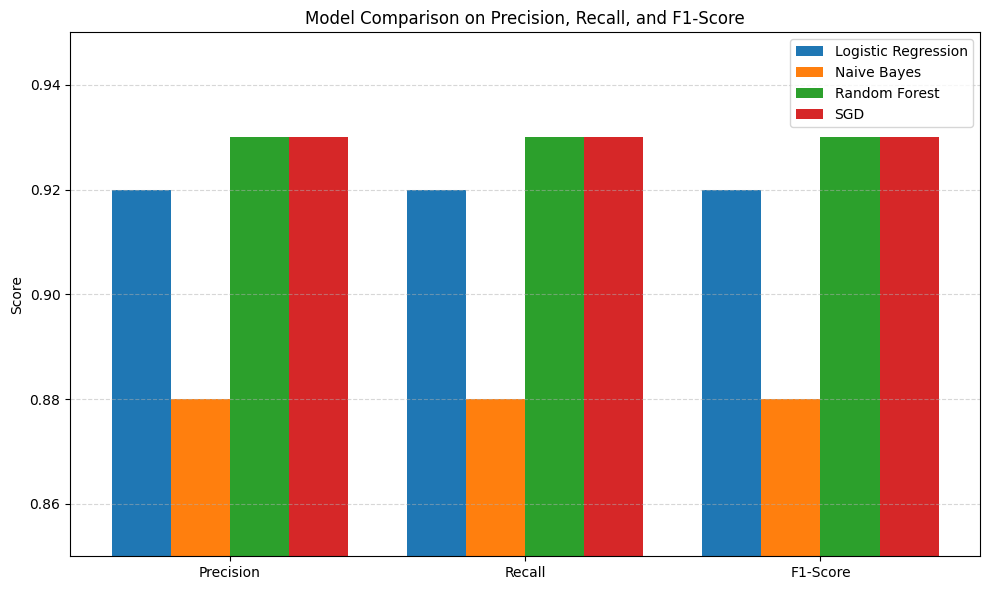

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and scores
metrics = ['Precision', 'Recall', 'F1-Score']
lr_scores = [0.92, 0.92, 0.92]
nb_scores = [0.88, 0.88, 0.88]
rf_scores = [0.93, 0.93, 0.93]
sgd_scores = [0.93, 0.93, 0.93]

# Set positions
x = np.arange(len(metrics))  # [0, 1, 2]
width = 0.2  # Width of each bar

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, lr_scores, width, label='Logistic Regression')
plt.bar(x - 0.5*width, nb_scores, width, label='Naive Bayes')
plt.bar(x + 0.5*width, rf_scores, width, label='Random Forest')
plt.bar(x + 1.5*width, sgd_scores, width, label='SGD')

# Aesthetics
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0.85, 0.95)
plt.title('Model Comparison on Precision, Recall, and F1-Score')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()



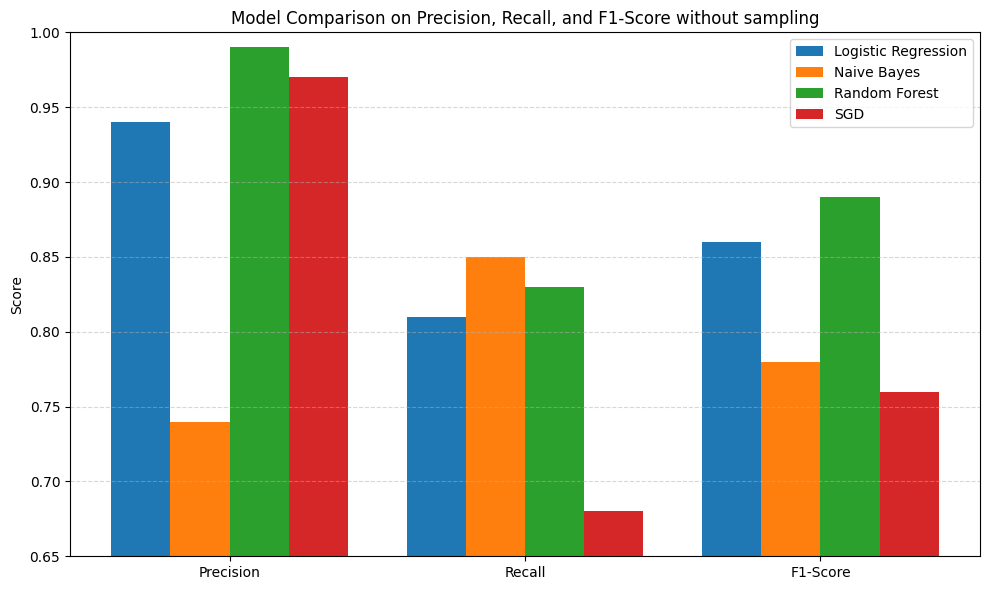

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and scores
metrics = ['Precision', 'Recall', 'F1-Score']
lr_scores = [0.94  ,    0.81  ,    0.86]
nb_scores = [0.74  ,    0.85  ,    0.78]
rf_scores = [0.99  ,    0.83   ,   0.89]
sgd_scores = [0.97   ,   0.68   ,   0.76]

# Set positions
x = np.arange(len(metrics))  # [0, 1, 2]
width = 0.2  # Width of each bar

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, lr_scores, width, label='Logistic Regression')
plt.bar(x - 0.5*width, nb_scores, width, label='Naive Bayes')
plt.bar(x + 0.5*width, rf_scores, width, label='Random Forest')
plt.bar(x + 1.5*width, sgd_scores, width, label='SGD')

# Aesthetics
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0.65, 1)
plt.title('Model Comparison on Precision, Recall, and F1-Score without sampling')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the model
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=30,        # Number of combinations to try
    cv=3,             # 3-fold cross-validation
    scoring='f1',     # Optimize F1-score
    random_state=42,
    n_jobs=-1
)

# Train the model
X_train,X_test,y_train,y_test = without_sampling(X,y)
random_search_rf.fit(X_train, y_train)

# Results
print("Best parameters:", random_search_rf.best_params_)
print("Best CV F1 score:", random_search_rf.best_score_)

# Predictions and final report
# model_without_sampling(random_search_rf.best_estimator_)
model_without_sampling(random_search_rf.best_estimator_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Best CV F1 score: 0.7545075908702183
RandomForestClassifier(bootstrap=False, n_estimators=300, random_state=42) without sampling
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.66      0.79       181

    accuracy                           0.98      3576
   macro avg       0.99      0.83      0.89      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the model
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=30,        # Number of combinations to try
    cv=3,             # 3-fold cross-validation
    scoring='f1',     # Optimize F1-score
    random_state=42,
    n_jobs=-1
)

# Train the model
X_train,X_test,y_train,y_test = random_sample(X,y)
random_search_rf.fit(X_train, y_train)

# Results
print("Best parameters:", random_search_rf.best_params_)
print("Best CV F1 score:", random_search_rf.best_score_)

# Predictions and final report
model_with_sampling(random_search_rf.best_estimator_)
# model_without_sampling(random_search_rf.best_estimator_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Best CV F1 score: 0.9264564711333128
RandomForestClassifier(bootstrap=False, n_estimators=300, random_state=42) with sampling
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       174
           1       0.91      0.97      0.94       173

    accuracy                           0.94       347
   macro avg       0.94      0.94      0.94       347
weighted avg       0.94      0.94      0.94       347

